In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model

In [9]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [13]:
LOSS_FUNCS = ['MIN', 'OI', 'SUMMIN']
BASELINES = ['SKOPT', 'RANDOM'] 

In [45]:
def average_min_found_values_across_rows(values):
    return np.mean(np.apply_along_axis(utils.min_up_to_k, 1, values), axis=0)

    def find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel, n_test=2000, n_steps=20, n_bumps=6.0):
    params = {
        'function': gp.normalized_gp_function,
        'kernel': gp.kernel_function(kernel),
        'dim': dim,
        'l': 2/n_bumps*np.sqrt(dim),
        'n_steps': n_steps+1,
        'n_test': n_test,
        'X_test': X_test,
        'A_test': A_test,
        'min_test': min_test,
        'max_test': max_test
    }
    return lstm_model.get_random_baseline(**params)

In [4]:
def find_y_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        res = sess.run(samples_y, feed_dict=feed_dict)

        return np.array(res).reshape(n_steps+1,-1).T

# print(model_name)
# compute_y_from_all_testing_data(utils.)
# compute_y_from_all_testing_data(model_name, dim=1, kernel='rbf', starting_point=[-1])

In [92]:
def plot_min_comparison_of_dim_and_kernel(dim, kernel):
    
    # load SKOPT
    for method in ['gp', 'gbrt']:
        skopt_y = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % (method, dim, kernel))
        skopt_y = average_min_found_values_across_rows(skopt_y)
        key = 'SKOPT-%s' % method.upper()
        plt.plot(skopt_y, label=key)
    
    # load test data
    X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    
    # load RANDOM    
    random_y = find_y_randomly(X_test, A_test, min_test, max_test, dim, kernel)
    random_y = average_min_found_values_across_rows(random_y)
    plt.plot(random_y, label='RANDOM')
    
    # load LSTM data
    for loss in LOSS_FUNCS:
        y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss)
        y_values = average_min_found_values_across_rows(y_values)
        plt.plot(y_values, label='LSTM-%s'%loss, marker = 'o')
    
    # using model trained on different kernel
    kernelb = 'rbf' if kernel is 'matern32' else 'matern32'
    y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernelb, loss='MIN')
    y_values = average_min_found_values_across_rows(y_values)

    plt.plot(y_values, label='LSTM-%s-%s'%('MIN',kernelb), marker = '^')

    
    xticks = range(0,random_y.shape[0],2)
    yticks = np.arange(-1.2, 0.2, 0.2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.title('%dD-%s' % (dim, kernel.upper()))

def plot_comparision_of_dim(dim):
    kernels = ['rbf', 'matern32']
    plt.figure(figsize=(15,4))
    
    for i in range(len(kernels)):
        plt.subplot(1,2,i+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernels[i])

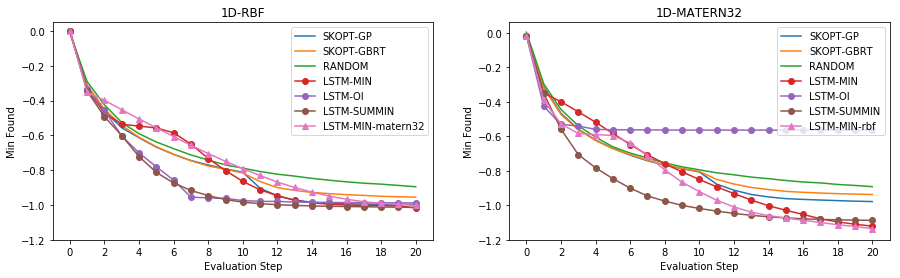

In [87]:
plot_comparision_of_dim(dim=1)

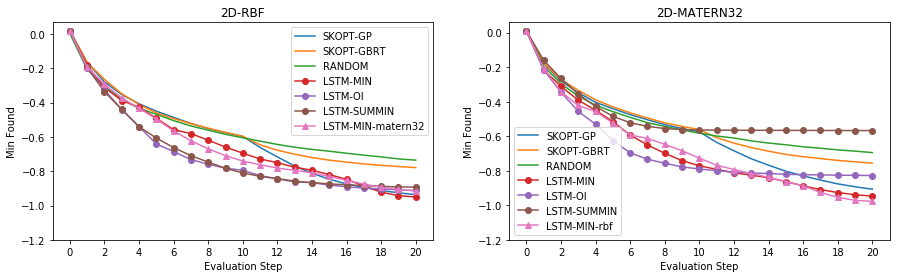

In [88]:
plot_comparision_of_dim(dim=2)

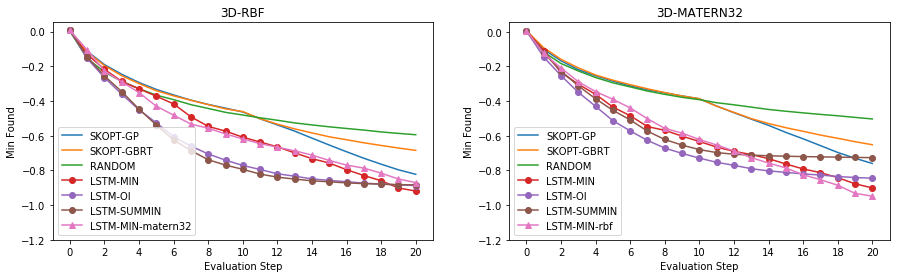

In [89]:
plot_comparision_of_dim(dim=3)

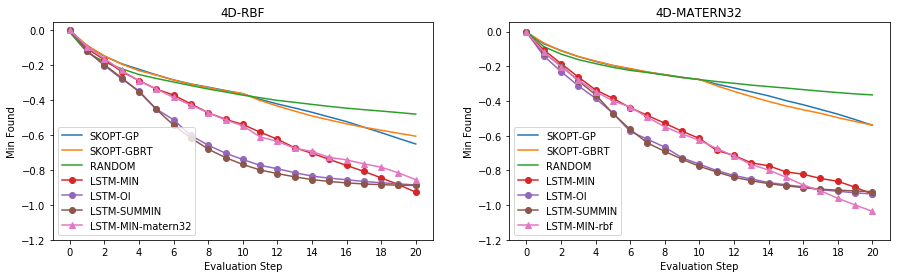

In [90]:
plot_comparision_of_dim(dim=4)

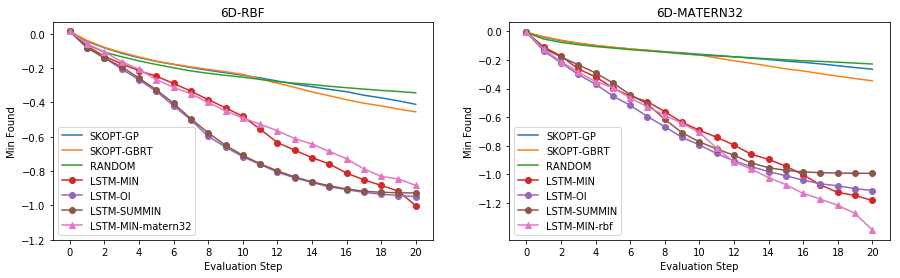

In [91]:
plot_comparision_of_dim(dim=6)

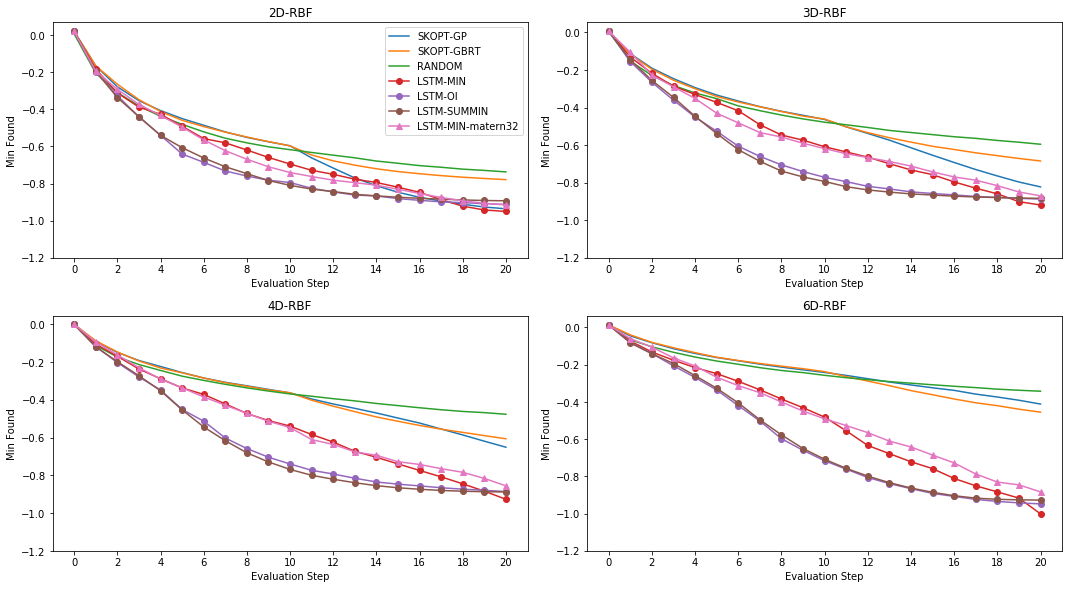

In [99]:
def plot_for_poster():
    dims = [2,3,4,6]
    total_dims = len(dims)
    kernels = ['rbf']
    plt.figure(figsize=(15,4*total_dims))
    count = 0
    for d in range(total_dims):
        dim = dims[d]
        for i in range(len(kernels)):
            plt.subplot(total_dims,2,count+1)
            plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernels[i])
            
            if i == 0 and d == 0:
                plt.legend()
            count = count + 1
    plt.tight_layout()
plot_for_poster()

In [104]:
def find_xy_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        y,x = sess.run([samples_y,samples_x], feed_dict=feed_dict)

        return y,x
X_test, A_test, min_test, max_test = utils.loadData(6, 'testing', 'rbf')
sy, sx = find_xy_from_lstm(X_test, A_test, min_test, max_test, 'rbf', 6, 'MIN')

In [170]:
np.array(sx)[2, 0,:]

array([ 0.14311759,  0.17867133, -0.08654706,  0.25449374,  0.58717263,
       -0.42871866], dtype=float32)

In [162]:
np.array(sy)[:5,0,:]

array([[ 0.32833433],
       [ 0.15137672],
       [-0.1297307 ],
       [-0.19622815],
       [-0.05825597]], dtype=float32)

In [163]:
idx = 0
length = 2/(6.0)*np.sqrt(6)

# data = np.array([-1]*6)
    data = np.array(sx)[:5, idx,:].reshape(1,1,6)
# data = np.array(sx)[:5, 0,:]
# print(data.shape)
gp.normalized_gp_function('np', X_test[np.newaxis, idx], A_test[np.newaxis, idx], min_test[np.newaxis, idx], max_test[np.newaxis, idx], \
    length, gp.kernel_function('rbf'), data)

array([[ 0.3283343 ,  0.15137662, -0.12973068, -0.19622818, -0.05825595]])

In [151]:
gp.rbf_kernel('np', np.array([1,1,1,1]).reshape(1,1,4), np.array([0,0,0,0]).reshape(1,1,4), 1)

array([[[ 0.01831564]]])

In [153]:
np.exp(-1* np.sum(np.power((np.array([1,1,1,1]) - np.array([0,0,0,0])),2) ))

0.018315638888734179

In [160]:
with tf.Session() as sess:
    x1 = tf.placeholder(tf.float32, [1,1,4])
    x2 = tf.placeholder(tf.float32, [1,1,4])
#     x2 = tf.Variable(4)
    
#         x_0 = tf.placeholder(tf.float32, [1,dim])

    rbf = gp.rbf_kernel('tf', x1, x2, 1)
    
    y  = sess.run(rbf, feed_dict={x1: np.array([1,1,1,1]).reshape(1,1,4), x2: np.array([1,1,1,1]).reshape(1,1,4)})

In [174]:
fun = lambda x, i : np.asscalar(gp.normalized_gp_function("np", X_test[np.newaxis,i], A_test[np.newaxis,i],\
                        min_test[np.newaxis,i], max_test[np.newaxis,i], length, gp.kernel_function('rbf'), \
                        np.array(x)[np.newaxis,np.newaxis,:]))
fun( np.array(sx)[4, 0,:], 0 )

-0.058255947018677645

In [173]:
np.array(sy)[:5,0,:]

array([[ 0.32833433],
       [ 0.15137672],
       [-0.1297307 ],
       [-0.19622815],
       [-0.05825597]], dtype=float32)